# Testo Esercizio

Esercizio n. 1 (Meo) in Laboratorio sugli alberi di decisione con sci kit learn:

a) applicate un sovracampionamento (artificial inflation) ad una classe nel training set con un determinato fattore: 10 (si pesi di più una delle classi tra virginica o versicolor che sono più difficili da discriminare). Si apprenda l'albero di decisione in queste condizioni. Attenzione che in questo caso la suddivisione tra training set e test set non deve rilasciare nel test set nessuna delle copie che abbiamo aggiunto, altrimenti si favorirebbe troppo il classificatore dando copie presenti nel training set anche nel test set. Quindi se volete usare la crossvalidation, dovete farla voi, da programma Python "a mano" (e non usare quella fornita da scikit learn, che non fa questo controllo).

b) modificare i pesi della stessa classe (si metta a 10 il peso per l'errata predizione ad esempio di Virginica in Versicolor o viceversa) e si apprenda l'albero in queste condizioni. Dovreste ottenere risultati simili a quelli del punto 1.
Si apprendano gli alberi cercando di evitare l'overfitting (migliorando l'errore sul test set) facendo 'tuning' degli iper-parametri: il minimo numero dei campioni per foglia, la massima profondità dell'albero, i parametri di minomo decremento dell'impurezza, massimo numero dei nodi foglia, ecc. Si consiglia di usare la classe gridSearchCV per questo tipo di tuning di molti parametri.


c) si costruisca la matrice di confusione dell'albero creato sul test set e la si visualizzi. 
si costruiscano le curve ROC (o curve nello spazio di coverage) e le si mostri per ciascun modello ad albero creato su un problema binario (con 1 sola classe positiva): per ciascun modello dovete costruire tre curve, una per ciascuna classe, considerata a turno la classe positiva.

# Import all libraries

In [1]:
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

#
## Define utility functions

In [59]:
def print_decision_tree(model,x_size, y_size, feature_names= None,  class_names=None):
    """
    Simply visualize a decision tree
    :param model: 
    :param x_size: 
    :param y_size: 
    :param feature_names: 
    :param class_names: 
    :return: 
    """
    fig = plt.figure(figsize=(x_size,y_size))
    tree.plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True)
    

def splitting_training_testing_set(dataset, num_examples):
    """
    Generate a random permutation of the indices of examples that will be later used for the training and the test set
    :param dataset: 
    :return: X_train, y_train, X_test, y_test
    """
    np.random.seed(0)
    indices = np.random.permutation(len(dataset.data))
    
    # We now decide to keep the last 10 indices for test set, the remaining for the training set
    indices_training=indices[:-num_examples]
    indices_test=indices[-num_examples:]
    
    X_train = dataset.data[indices_training] 
    y_train = dataset.target[indices_training]
    X_test  = dataset.data[indices_test] 
    y_test  = dataset.target[indices_test]
    
    return X_train, y_train, X_test, y_test


def artificial_inflaction(ratio, label, X_train, y_train):
    """
    Perform an artificial inflation on a given dataset by a given ratio
    :param ratio: 
    :return: 
    """
    new_X_train = []
    new_y_train = []
    for i,el in enumerate(X_train):
        if y_train[i] == label:
            for j in range(0, ratio):
                new_X_train.append(el)
                new_y_train.append(y_train[i])    
        else:
            new_X_train.append(el)
            new_y_train.append(y_train[i])
    
    return new_X_train, new_y_train


def evaluate_model(y_test, predicted):
    """
    Evaluate the model on the test set
    :param y_test: 
    :param predicted: 
    :return: accuracy, precision, recall, f1
    """
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average='macro')
    recall = recall_score(y_test, predicted, average='macro')
    f1 = f1_score(y_test, predicted, average='macro')
    
    return accuracy, precision, recall, f1


def print_confusion_matrix(y_test, predicted, target_names, sizeX, sizeY):
    """
    Print the confusion matrix
    :param y_test: 
    :param predicted: 
    :return: 
    """
    
    matrix = confusion_matrix(y_test, predicted)
    plot_confusion_matrix(conf_mat=matrix, figsize=(sizeX, sizeY), cmap=plt.cm.Greens, class_names=target_names)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()


def display_ROC_curve(y_test, y_pred, target_names, sizeX, sizeY):
    """
    Display ROC curve
    :param y_test: 
    :param y_pred: 
    :param target_names: 
    :return: 
    """
    figure, axis = plt.subplots(1, 3, figsize=(sizeX, sizeY)) 
    colors = ['tab:orange', 'tab:green', 'tab:purple']
    for i,label in enumerate(target_names):
        
        fpr, tpr, _ = roc_curve(np.where(y_test==i, 1, -1), np.where(y_pred==i, 1, -1))
        axis[i].plot(fpr, tpr)
        axis[i].set_title(f'Model: {i} | ROC curve {target_names[i]} VS others')
        roc_auc = metrics.auc(fpr, tpr)
        
        axis[i].plot(fpr,tpr, colors[i], label="Roc AUC: " + str(round(roc_auc,3))) 
        axis[i].legend(loc="upper right")
        axis[i].set_title("ROC curve assuming positive class: " + label) 
        #display.plot()
    
    for ax in axis.flat: ax.set(xlabel='False Positive rate', ylabel='True Positive rate')
    plt.show()


def tuning_model(X_train, y_train, parameters):
    """
    Tuning the model performing a grid search analysis
    :param X_train: training set
    :param y_train: testing set
    :param parameters:  list of parameters for tuning the model
    :return: best params for the model considering the composition of the dataset
    """    
    model = tree.DecisionTreeClassifier()
    grid_model = GridSearchCV(model, parameters)
    grid_model.fit(X_train, y_train)
    return grid_model.best_params_

    

#
## Load Iris Dataset
### Print some information about the Iris Dataset

In [15]:
iris = load_iris()
print("Printing some information about the IRIS dataset:\n")
print("Number of instances in the dataset: ", iris.data.shape[0])
print("Number of features in the dataset: ", len(iris.feature_names))
print("Feature names: ", iris.feature_names)
print("Number of classes in the dataset: ", len(iris.target_names))
print("Name of the classes: ", iris.target_names)


# Split the dataset in Training and testing set, using 40 examples for the test set
num_examples = 40
X_train, y_train, X_test, y_test = splitting_training_testing_set(iris, num_examples)

print(f"\nSplitting the dataset in training and testing set using {num_examples} examples for the test set")
print("Lenght train: ", len(X_train))
print("Lenght test: ", len(X_test))

for i in range(0,3): 
    print(f'Number of expamples in the test_set of class {i}: {len([el for el in y_test if el == i])}')


Printing some information about the IRIS dataset:

Number of instances in the dataset:  150
Number of features in the dataset:  4
Feature names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of classes in the dataset:  3
Name of the classes:  ['setosa' 'versicolor' 'virginica']

Splitting the dataset in training and testing set using 40 examples for the test set
Lenght train:  110
Lenght test:  40
Number of expamples in the test_set of class 0: 14
Number of expamples in the test_set of class 1: 14
Number of expamples in the test_set of class 2: 12


#
## Setting the iperparameter for the Grid search task (tuning the model)

In [9]:
parameters = {'criterion':('entropy', 'gini', "log_loss"), 
          'splitter': ('best', 'random'),
          'max_depth': (4, 5, 10), 
          'min_samples_split': (2,10,25),
          'min_samples_leaf': (1,10,25),
          'min_impurity_decrease': (0.0, 0.1, 1)}

#
# Training the model before the artificial inflaction
# Classifier 1

Tuning the iperparameter!
Best Parameters: 
{'criterion': 'log_loss', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 25, 'splitter': 'random'}

...Training the model with the best iperparameter selected...
Accuracy:  0.95
Average (macro) precision:  0.9523809523809524
Average (macro) recall:  0.9523809523809524
Average (macro) F1 score:  0.9487179487179486


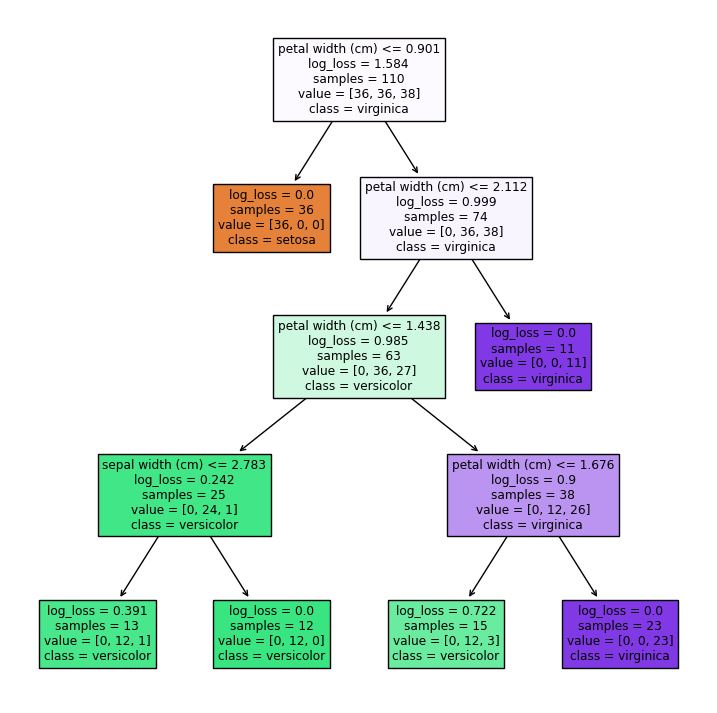

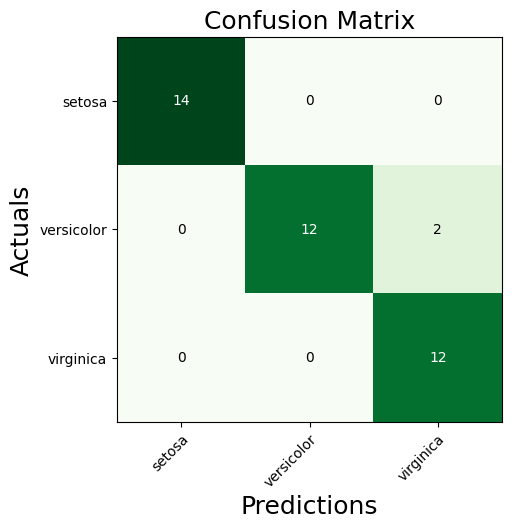

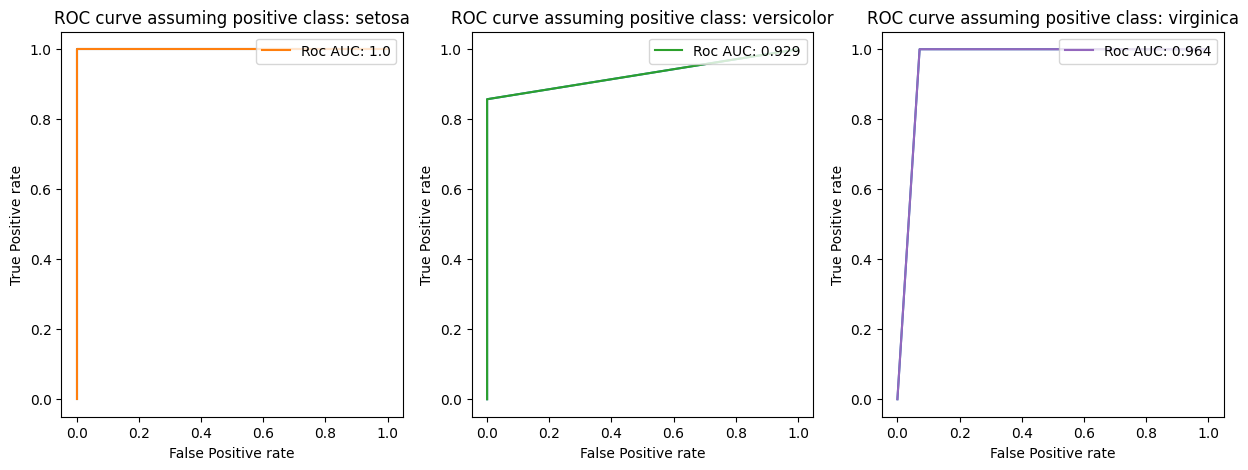

In [60]:
print("Tuning the iperparameter!")
grid_search_params = tuning_model(X_train,y_train,parameters)
print("Best Parameters: ")
print(grid_search_params)

clf = tree.DecisionTreeClassifier(criterion=grid_search_params['criterion'],
                                  min_samples_leaf=grid_search_params['min_samples_leaf'],
                                  random_state=300,
                                  max_depth=grid_search_params['max_depth'],
                                  min_impurity_decrease=grid_search_params['min_impurity_decrease'],
                                  min_samples_split=grid_search_params['min_samples_split'],
                                  splitter=grid_search_params['splitter'],
                                  class_weight={0:1,1:1,2:1})

print("\n...Training the model with the best iperparameter selected...")
clf = clf.fit(X_train, y_train)
print_decision_tree(clf, 9,9, feature_names=iris.feature_names,class_names=iris.target_names)
predicted_y_test = clf.predict(X_test)

accuracy, precision, recall, f1 = evaluate_model(y_test, predicted_y_test)
print("Accuracy: ", accuracy)
print("Average (macro) precision: ", precision)
print("Average (macro) recall: ", recall)
print("Average (macro) F1 score: ", f1)

print_confusion_matrix(y_test,predicted_y_test, iris.target_names, 5,5)
display_ROC_curve(y_test, predicted_y_test, iris.target_names, 15,5)


# Training the model after artificial inflactioning the Versicolor class
# Classifier 2
### ratio = 10
### Versicolor == label 1

Artificial inflacting the Versicolor class with a ratio of 10
Printing some information about the NEW IRIS dataset:

Number of instances in the dataset:  474
Lenght train:  434
Lenght test:  40

Tuning the iperparameter 
Best Parameters: 
{'criterion': 'gini', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 25, 'splitter': 'random'}

...Training the model with the best iperparameter selected...
Accuracy:  0.95
Average (macro) precision:  0.9523809523809524
Average (macro) recall:  0.9523809523809524
Average (macro) F1 score:  0.9487179487179486


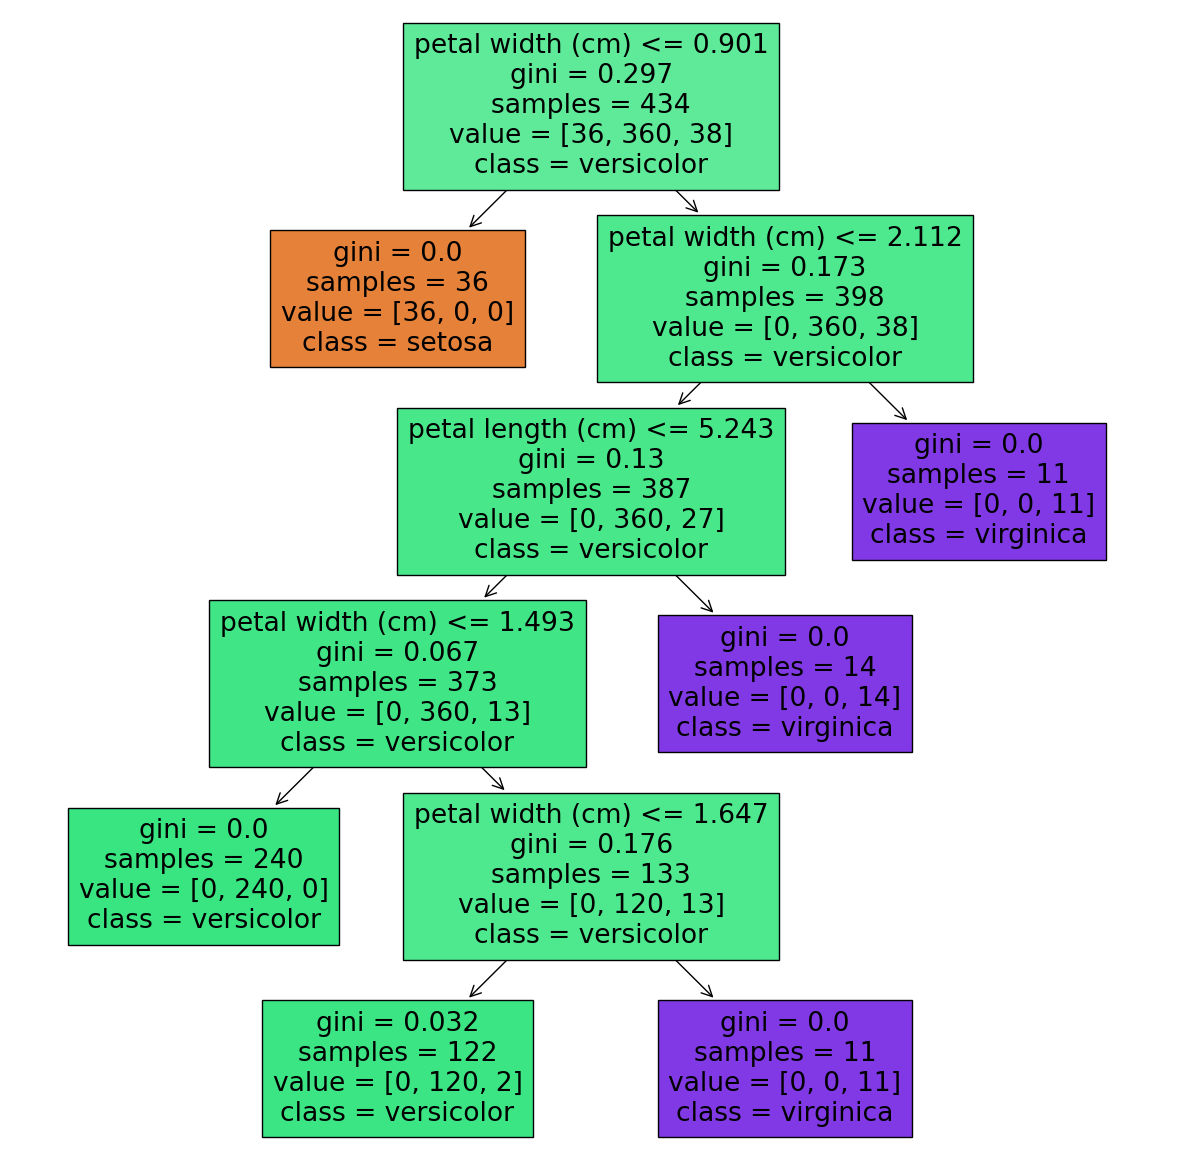

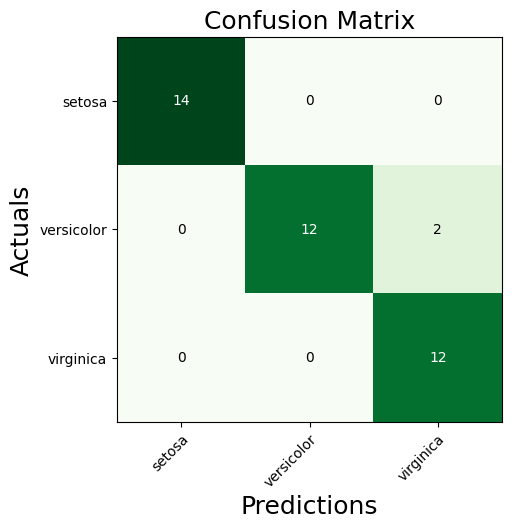

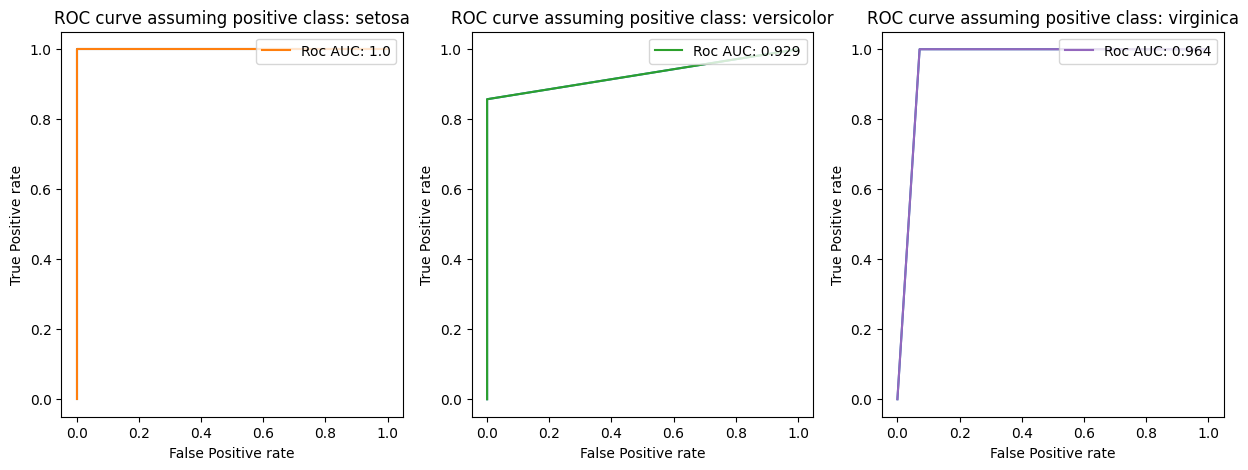

In [22]:
ratio = 10
print(f"Artificial inflacting the Versicolor class with a ratio of {ratio}")
new_X_train, new_y_train = artificial_inflaction(ratio, 1, X_train, y_train)

print("Printing some information about the NEW IRIS dataset:\n")
print("Number of instances in the dataset: ", (len(new_X_train) + len(X_test)))
print("Lenght train: ", len(new_X_train))
print("Lenght test: ", len(X_test))

print("\nTuning the iperparameter ")
params_versicolor = tuning_model(new_X_train,new_y_train,parameters)
print("Best Parameters: ")
print(params_versicolor)


clf = tree.DecisionTreeClassifier(criterion=params_versicolor['criterion'],
                                  min_samples_leaf=params_versicolor['min_samples_leaf'],
                                  random_state=300,
                                  max_depth=params_versicolor['max_depth'],
                                  min_impurity_decrease=params_versicolor['min_impurity_decrease'],
                                  min_samples_split=params_versicolor['min_samples_split'],
                                  splitter=params_versicolor['splitter'],
                                  class_weight={0:1,1:1,2:1})

print("\n...Training the model with the best iperparameter selected...")
clf = clf.fit(new_X_train, new_y_train)
print_decision_tree(clf, 15,15, feature_names=iris.feature_names,class_names=iris.target_names)

predicted_y_test = clf.predict(X_test)
accuracy, precision, recall, f1 = evaluate_model(y_test, predicted_y_test)
print("Accuracy: ", accuracy)
print("Average (macro) precision: ", precision)
print("Average (macro) recall: ", recall)
print("Average (macro) F1 score: ", f1)

print_confusion_matrix(y_test,predicted_y_test, iris.target_names, 5,5)
display_ROC_curve(y_test, predicted_y_test, iris.target_names, 15,5)

# Training the model after artificial inflactioning the Virginica class
# Classifier 3
### ratio = 10
### Virginica == label 2

Artificial inflacting the Virginica class with a ratio of 10
Printing some information about the NEW IRIS dataset:

Number of instances in the dataset:  492
Lenght train:  452
Lenght test:  40

Tuning the iperparameter 
Best Parameters: 
{'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}

...Training the model with the best iperparameter selected...
Accuracy:  0.925
Average (macro) precision:  0.9333333333333332
Average (macro) recall:  0.9285714285714285
Average (macro) F1 score:  0.9229629629629629


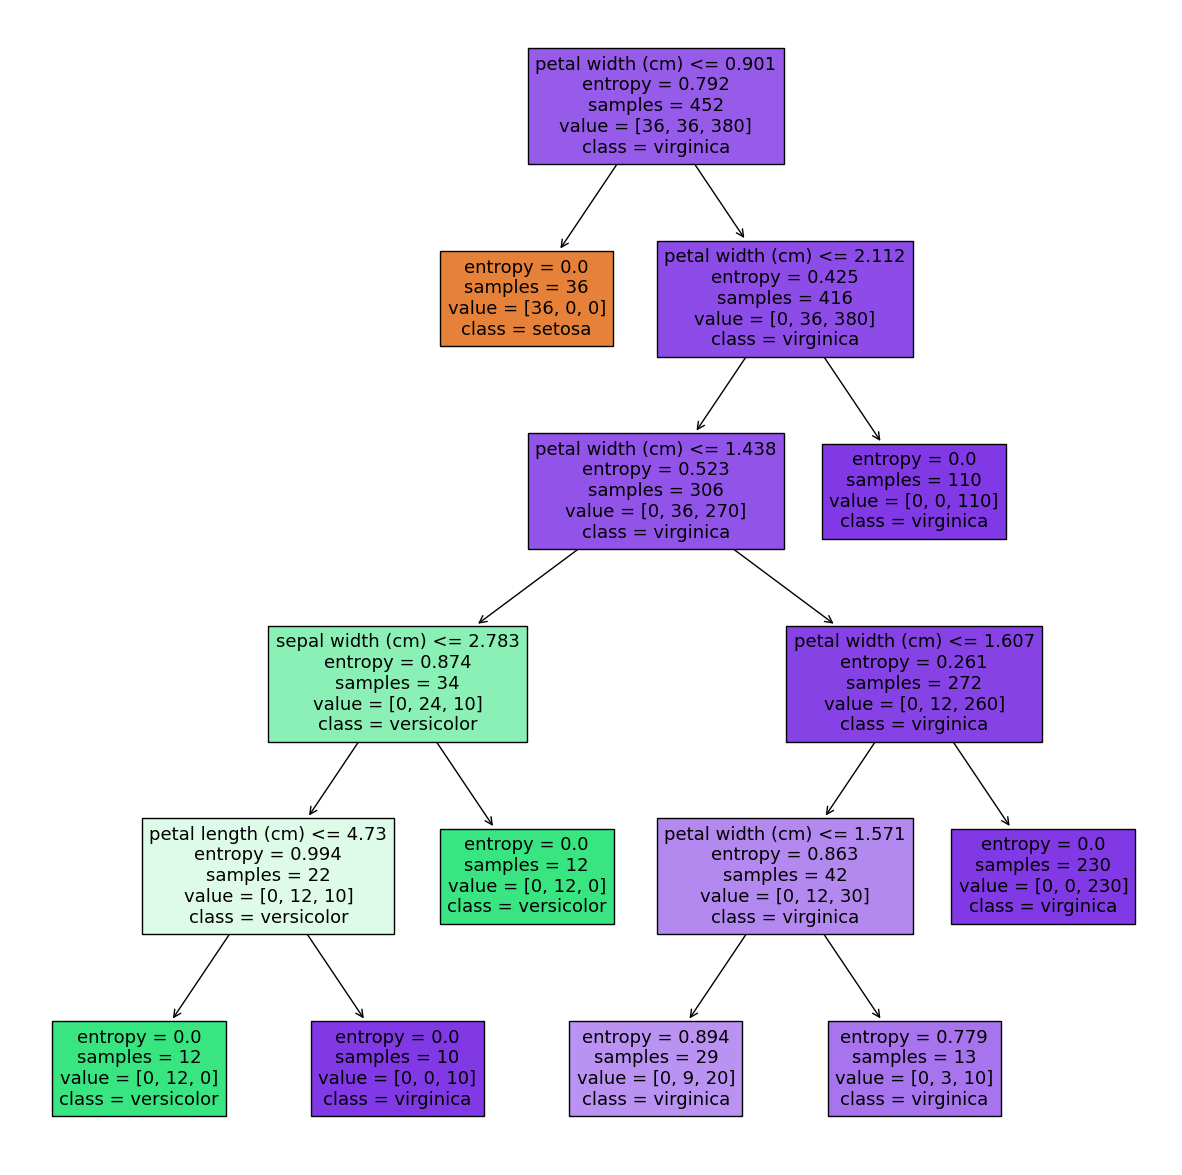

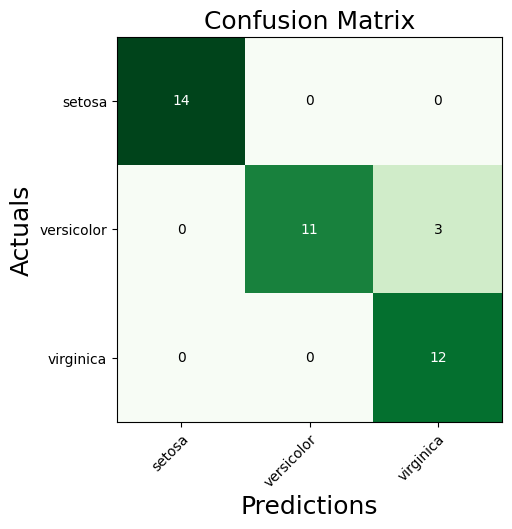

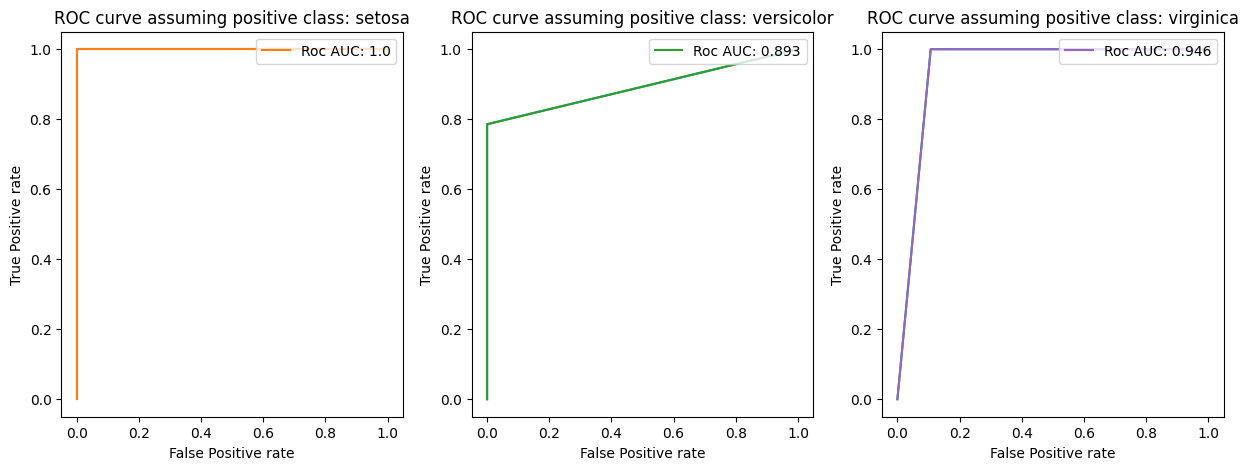

In [52]:
ratio = 10
print(f"Artificial inflacting the Virginica class with a ratio of {ratio}")
new_X_train, new_y_train = artificial_inflaction(ratio, 2, X_train, y_train)

print("Printing some information about the NEW IRIS dataset:\n")
print("Number of instances in the dataset: ", (len(new_X_train) + len(X_test)))
print("Lenght train: ", len(new_X_train))
print("Lenght test: ", len(X_test))

print("\nTuning the iperparameter ")
params_virginica = tuning_model(new_X_train,new_y_train,parameters)
print("Best Parameters: ")
print(params_virginica)


clf = tree.DecisionTreeClassifier(criterion=params_virginica['criterion'],
                                  min_samples_leaf=params_virginica['min_samples_leaf'],
                                  random_state=300,
                                  max_depth=params_virginica['max_depth'],
                                  min_impurity_decrease=params_virginica['min_impurity_decrease'],
                                  min_samples_split=params_virginica['min_samples_split'],
                                  splitter=params_virginica['splitter'],
                                  class_weight={0:1,1:1,2:1})

print("\n...Training the model with the best iperparameter selected...")
clf = clf.fit(new_X_train, new_y_train)
print_decision_tree(clf, 15,15, feature_names=iris.feature_names,class_names=iris.target_names)
predicted_y_test = clf.predict(X_test)

accuracy, precision, recall, f1 = evaluate_model(y_test, predicted_y_test)
print("Accuracy: ", accuracy)
print("Average (macro) precision: ", precision)
print("Average (macro) recall: ", recall)
print("Average (macro) F1 score: ", f1)

print_confusion_matrix(y_test,predicted_y_test, iris.target_names,5,5)
display_ROC_curve(y_test, predicted_y_test, iris.target_names, 15,5)

# best parameters = {'criterion': 'gini', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

# Setting to 10 the weights for misclassification between versicolor in virginica
# Classifier 4
## modified weight of class 1: Versicolor:


...Training the model with the best iperparameter selected...
Accuracy:  0.95
Average (macro) precision:  0.9523809523809524
Average (macro) recall:  0.9523809523809524
Average (macro) F1 score:  0.9487179487179486


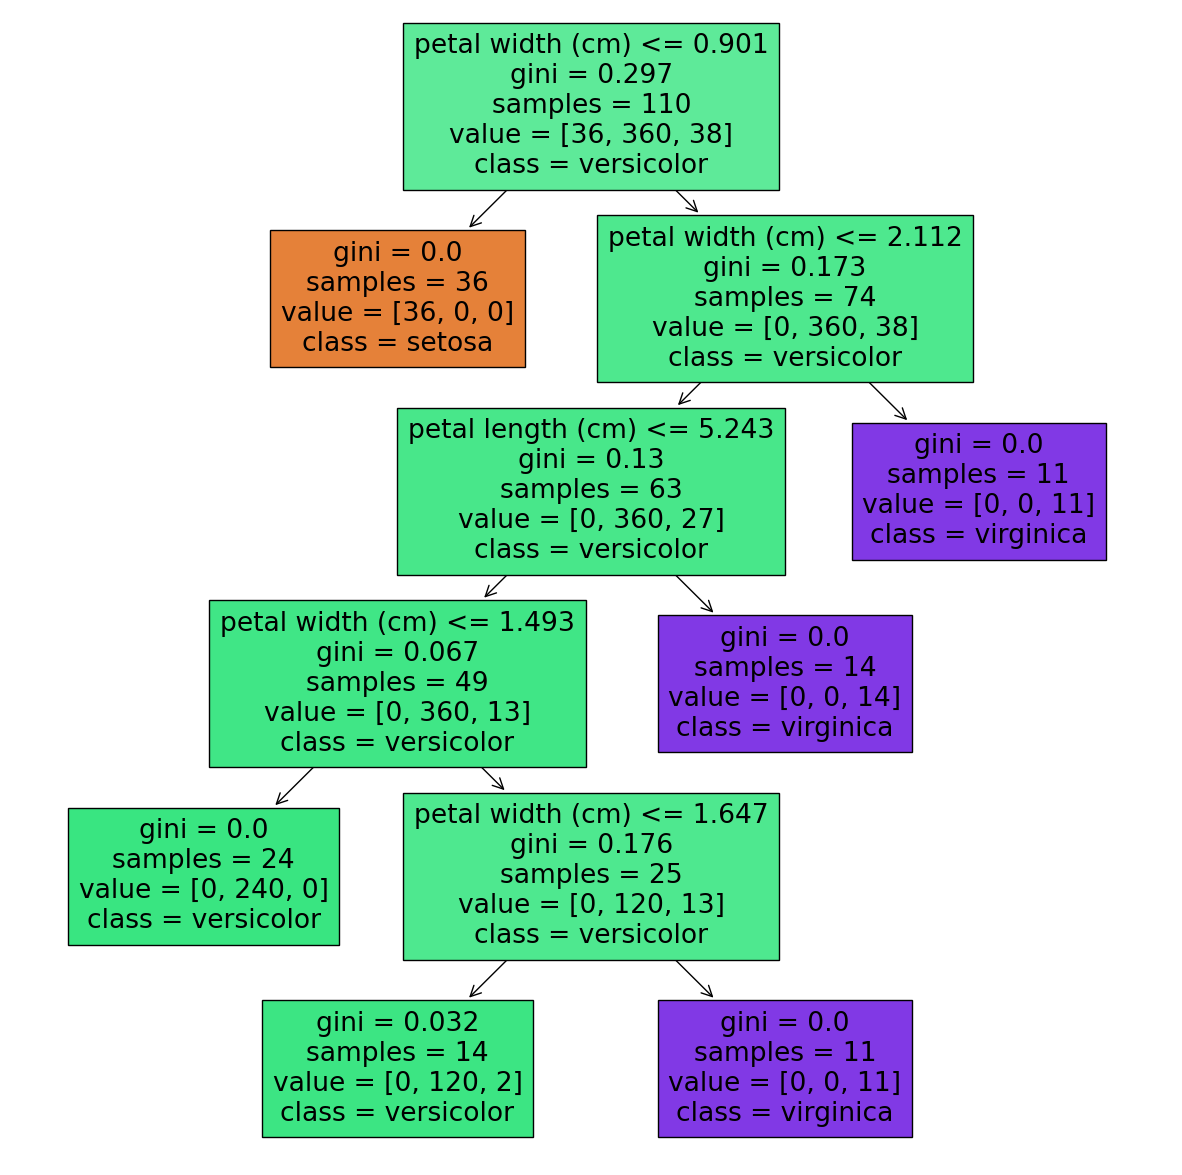

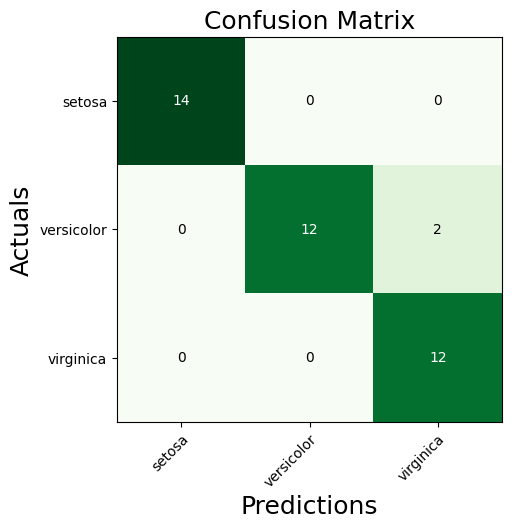

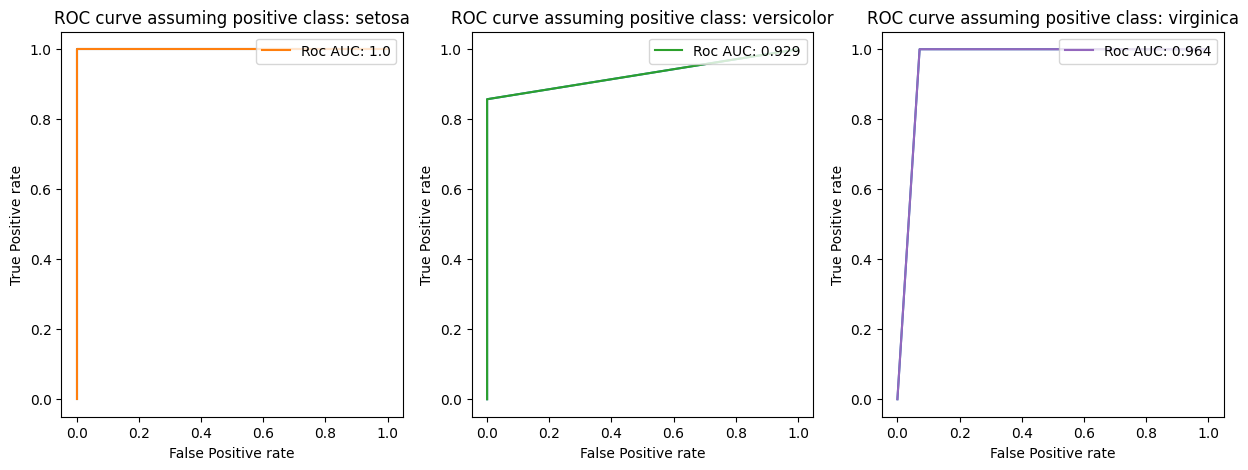

In [58]:
clf = tree.DecisionTreeClassifier(criterion=params_versicolor['criterion'],
                                  min_samples_leaf=params_versicolor['min_samples_leaf'],
                                  random_state=300,
                                  max_depth=params_versicolor['max_depth'],
                                  min_impurity_decrease=params_versicolor['min_impurity_decrease'],
                                  min_samples_split=params_versicolor['min_samples_split'],
                                  splitter=params_versicolor['splitter'],
                                  class_weight={0:1,1:10,2:1})

print("\n...Training the model with the best iperparameter selected...")
clf = clf.fit(X_train, y_train)
print_decision_tree(clf, 15,15, feature_names=iris.feature_names,class_names=iris.target_names)

predicted_y_test = clf.predict(X_test)
accuracy, precision, recall, f1 = evaluate_model(y_test, predicted_y_test)
print("Accuracy: ", accuracy)
print("Average (macro) precision: ", precision)
print("Average (macro) recall: ", recall)
print("Average (macro) F1 score: ", f1)

print_confusion_matrix(y_test,predicted_y_test, iris.target_names,5,5)
display_ROC_curve(y_test, predicted_y_test, iris.target_names, 15,5)


# Setting to 10 the weights for misclassification between virginica into versicolor
# Classifier 5
## modified weight of class 2: Virginica


...Training the model with the best iperparameter selected...
Accuracy:  0.925
Average (macro) precision:  0.9333333333333332
Average (macro) recall:  0.9285714285714285
Average (macro) F1 score:  0.9229629629629629


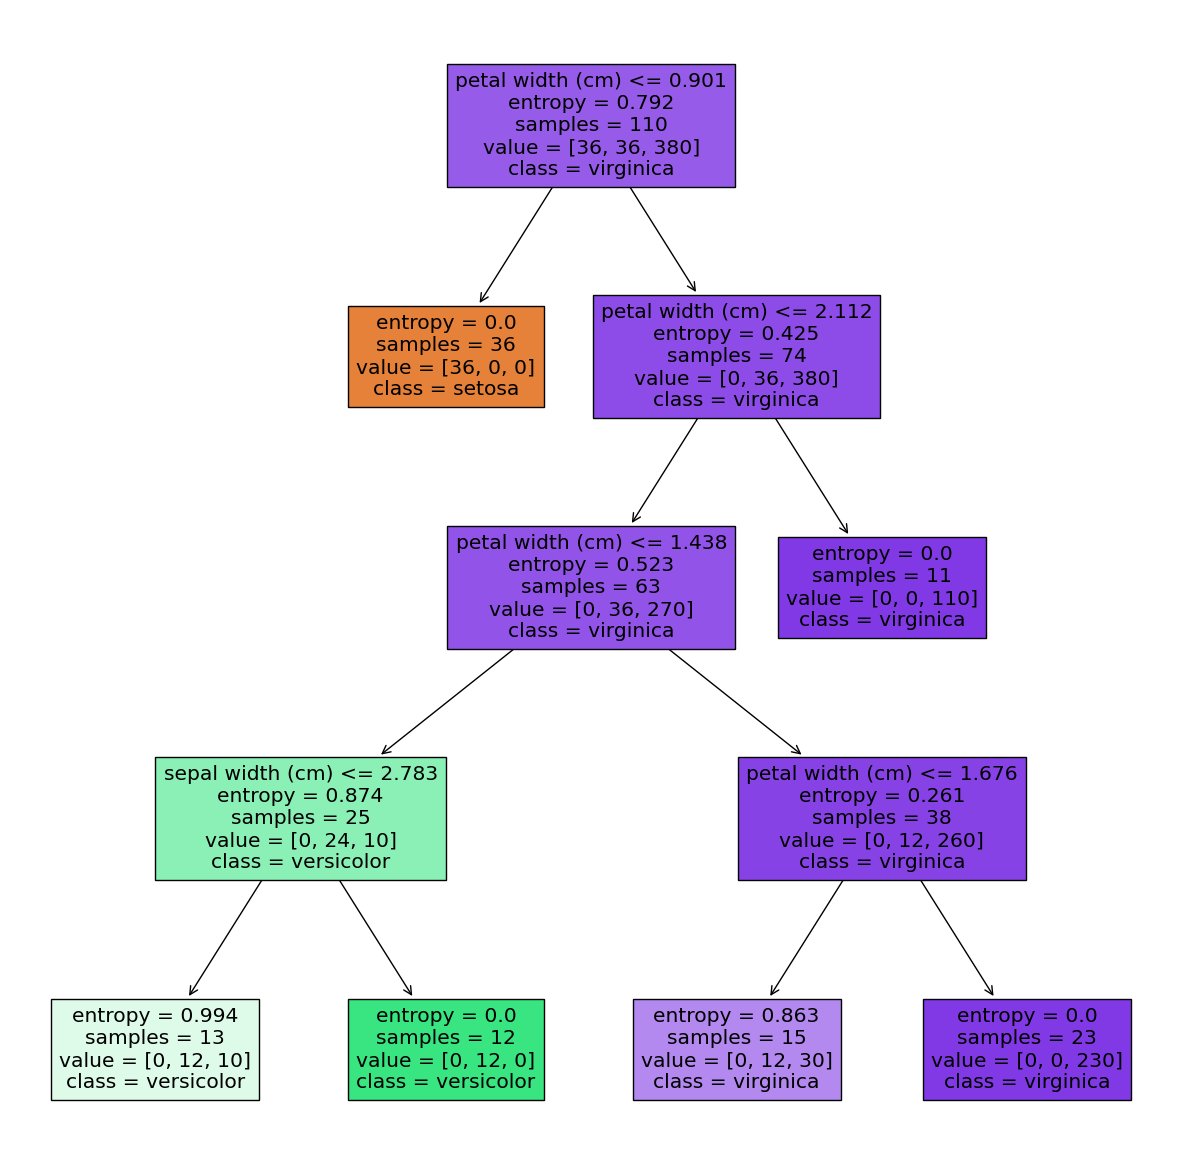

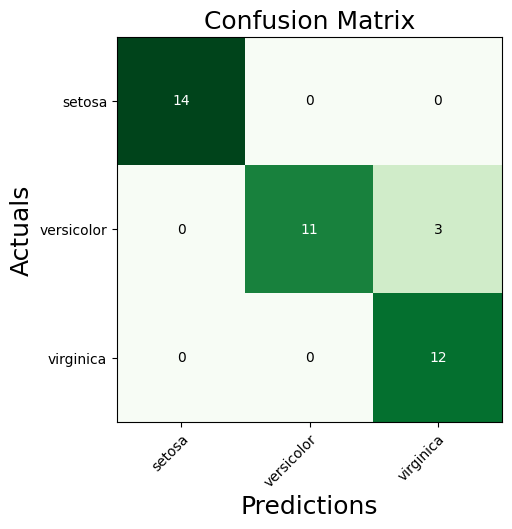

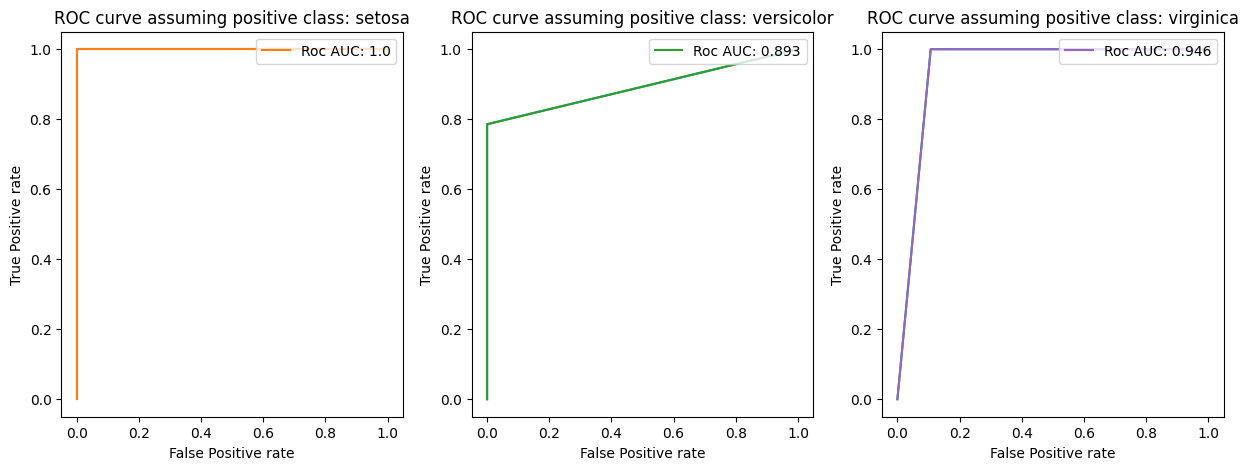

In [54]:
clf = tree.DecisionTreeClassifier(criterion=params_virginica['criterion'],
                                  min_samples_leaf=params_virginica['min_samples_leaf'],
                                  random_state=300,
                                  max_depth=params_virginica['max_depth'],
                                  min_impurity_decrease=params_virginica['min_impurity_decrease'],
                                  min_samples_split=params_virginica['min_samples_split'],
                                  splitter=params_virginica['splitter'],
                                  class_weight={0:1,1:1,2:10})

print("\n...Training the model with the best iperparameter selected...")
clf = clf.fit(X_train, y_train)
print_decision_tree(clf, 15,15, feature_names=iris.feature_names,class_names=iris.target_names)

predicted_y_test = clf.predict(X_test)
accuracy, precision, recall, f1 = evaluate_model(y_test, predicted_y_test)
print("Accuracy: ", accuracy)
print("Average (macro) precision: ", precision)
print("Average (macro) recall: ", recall)
print("Average (macro) F1 score: ", f1)

print_confusion_matrix(y_test,predicted_y_test, iris.target_names,5,5)
display_ROC_curve(y_test, predicted_y_test, iris.target_names, 15,5)